In [14]:
import pandas as pd
import numpy as np
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.colors as pc
from modified_spectral_method import recursive_spectral_method, create_correlation_matrix, calculate_C_g
from modified_louvain_method import *
from itertools import product
from collections import Counter

# Function to plot pie charts by user-selected criteria (sector, region, or country) using Plotly
def plot_group_distribution(groups, df, criteria='Sector'):
    
    unique_sectors = df['Sector'].unique()
    unique_regions = df['Region'].unique()
    unique_countries = df['Country'].unique()

    # Define a more distinguishable color palette
    color_palette = pc.qualitative.Plotly + pc.qualitative.Dark24 + pc.qualitative.Light24
    sector_colors = dict(zip(unique_sectors, color_palette[:len(unique_sectors)]))
    region_colors = dict(zip(unique_regions, color_palette[:len(unique_regions)]))
    country_colors = dict(zip(unique_countries, color_palette[:len(unique_countries)]))

    if criteria not in ['Sector', 'Region', 'Country']:
        raise ValueError("Invalid criteria! Use 'Sector', 'Region', or 'Country'.")

    color_dict_sector = {'Sector': sector_colors, 'Region': region_colors, 'Country': country_colors}
    color_dict = color_dict_sector[criteria]
    
    # Setting up the subplot grid
    num_groups = len(groups)
    ncols = 3  # Maximum of 3 columns
    nrows = (num_groups + ncols - 1) // ncols  # Calculate required rows based on number of groups
    fig = make_subplots(rows=nrows, cols=ncols, subplot_titles=[f'Group {i+1}' for i in range(num_groups)], specs=[[{'type': 'domain'}]*ncols]*nrows)
    
    # Add each group's pie chart to the subplots
    for idx, tickers in enumerate(groups):
        row = idx // ncols + 1
        col = idx % ncols + 1

        # Filter data for the current group
        group_data = df[df['Ticker'].isin(tickers)]

        # Count the occurrences of each sector, region, or country
        counts = group_data[criteria].value_counts()
        
        # Prepare colors for the pie chart
        colors = [color_dict[key] for key in counts.index]

        # Add the pie chart to the subplot
        fig.add_trace(go.Pie(labels=counts.index, values=counts, marker=dict(colors=colors), showlegend=False), row=row, col=col)

    # Create a legend manually at the bottom of the figure
    fig.update_layout(
        title_text=f"{criteria} Distribution for Groups",
        showlegend=True,
        legend=dict(
            title=criteria,
            orientation="h",
            yanchor="bottom",
            y=-0.3,  # Adjust to move legend up or down
            xanchor="center",
            x=0.5,
            font=dict(size=10)
        )
    )

    # Add dummy traces to populate the shared legend with colors
    for label, color in color_dict.items():
        fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color=color), name=label))

    fig.show()


# if __name__ == '__main__':
#     df = pd.read_csv('metadata.csv')
#     correlation_matrix, T, N, company_names = create_correlation_matrix('eur_data_standardized_returns.csv')  
#     C_g = calculate_C_g(correlation_matrix, T, N)
#     result_communities, company_communities, modularities = recursive_spectral_method(C_g, company_names, min_size=2, modularity_threshold=0.00001)

#     plot_group_distribution(company_communities, df, criteria='Region')


In [3]:
df = pd.read_csv('metadata.csv')
correlation_matrix, T, N, company_names = create_correlation_matrix('eur_data_standardized_returns.csv')  
C_g = calculate_C_g(correlation_matrix, T, N)
result_communities, company_communities, modularities = recursive_spectral_method(C_g, company_names, min_size=2, modularity_threshold=0.00001)

In [4]:
com_num = 1
for community in company_communities:
    print(f"community number {com_num} is {community}")
    com_num += 1

community number 1 is ['AAUK', 'ACCOR', 'AIRLIQ', 'AKZO', 'ALSTOM', 'ARMLL', 'ATSPA', 'AZN', 'BAD', 'BAPLC', 'BASFSE', 'BATSLN', 'BMW', 'BOUY', 'BPLN', 'BRITEL-BritTel', 'BYIF', 'CARR', 'CENTRI', 'CLAR', 'CONTI', 'CPGLN', 'DAMLR', 'DANONE', 'DEXO', 'DIAG', 'DT', 'EDF', 'ELTLX', 'ENI', 'EXPGRL-EXPFIN', 'FORTUM', 'FSEKGA', 'GLCORE', 'GSK', 'HEI', 'HEIANA', 'HOFP', 'ITV', 'KDSM', 'KPN', 'LINDE', 'LNX', 'LUFTHA', 'MKS-M+SPlc', 'MOET', 'NESTLE', 'NGP', 'NOKIA', 'NXT', 'PERNOD', 'PEUGOT', 'PREUSS', 'PSON', 'PUBFP', 'RDSPLC', 'RENAUL', 'RNTKIL', 'ROLLS', 'SBRY', 'SIEM', 'SOLVAY', 'STGOBN', 'STM', 'STORA', 'SYNNVX', 'TATELN', 'TELNOR', 'TKA', 'TKAGR', 'TOTALN', 'TSCO', 'ULVR', 'UPMKYM', 'UU', 'VEOLIA', 'VINCI', 'VIVNDI', 'VLOF', 'VLVY', 'VOD', 'VW', 'WENL', 'WOLKLU', 'WPPGRP-2005']
community number 2 is ['ACAFP', 'AEGON', 'ALPHBK', 'ALZSE', 'ASSGEN', 'AVLN', 'AXAF', 'BACR-Bank', 'BACRED', 'BBVSM', 'BFCM', 'BNP', 'CMZB', 'CSGAG', 'DANBNK', 'DB', 'DBR', 'EDP', 'ENEL', 'FRTR', 'GROUPE', 'IBERDU',

In [5]:
def split_data_by_interval(file_path, interval='2Y'):
    """
    Splits data into user-defined intervals.
    Args:
        file_path (str): Path to the CSV file containing the data.
        interval (str): Interval string (e.g., '1Y' for yearly, '2Y' for two years).
    Returns:
        dict: A dictionary where keys are interval ranges, and values are dataframes for each interval.
    """
    # Load the data
    df = pd.read_csv(file_path, parse_dates=['Date'])
    
    # Ensure the 'Date' column is the index
    df.set_index('Date', inplace=True)
    
    # Group the data by the specified interval
    grouped = df.resample(interval)
    intervals = {f"{group.index.min().year}_{group.index.max().year}": group for _, group in grouped if not group.empty}
    
    return intervals

def analyze_intervals(file_path, interval='2YE', min_size=2, modularity_threshold=0.00001, method="louvain"):
    """
    Analyze communities for each interval and return results.
    Args:
        file_path (str): Path to the standardized returns file.
        interval (str): Resampling interval (e.g., '1Y', '2Y').
        min_size (int): Minimum size of communities.
        modularity_threshold (float): Threshold for modularity improvement.
    Returns:
        dict: Results containing communities and modularities for each interval.
    """
    # Split the data into intervals
    intervals = split_data_by_interval(file_path, interval=interval)
    results = {}

    # Analyze each interval
    for key, interval_data in intervals.items():
        # Ensure the data is sufficient
        if len(interval_data) < 2:
            print(f"Skipping interval {key} due to insufficient data.")
            continue
        
        # Compute correlation matrix
        correlation_matrix, T, N, company_names = create_correlation_matrix(interval_data)
        C_g = calculate_C_g(correlation_matrix, T, N)

        if method == "louvain":
            # Detect communities using modified Louvain method
            communities = modified_louvain(C_g)
    
            # Calculate modularities
            modularity = calculate_global_modularity(communities, C_g)
            # Assign modularities for consistency
            modularities = [modularity]  # Single modularity value in a list for consistency
    
            # Map communities to company names
            company_communities = map_communities_to_company_names(communities, company_names)
        else:
            # Detect communities
            result_communities, company_communities, modularities = recursive_spectral_method(
                C_g, company_names, min_size=min_size, modularity_threshold=modularity_threshold
            )
        # Store results for this interval
        results[key] = {
            'communities': company_communities,
            'modularities': modularities
        }
        print(f"Interval {key}: Found {len(company_communities)} communities.")
    
    return results


# Example usage
if __name__ == '__main__':
    file_path = 'FTSE_100_standardized_returns.csv'
    interval = '2YE'  # Change to '1Y', '6M', etc., for different intervals
    results = analyze_intervals(file_path, interval=interval, method="louvain")

    # Example: Access communities and modularities for a specific interval
    for interval_key, result in results.items():
        print(f"Interval {interval_key}:")
        print(f"Communities: {result['communities']}")
        print(f"Modularities: {result['modularities']}")


Detected 2 Initially
Final number of communities: 2
Interval 2001_2001: Found 2 communities.
Detected 3 Initially
Final number of communities: 3
Interval 2002_2003: Found 3 communities.
Detected 5 Initially
Final number of communities: 5
Interval 2004_2005: Found 5 communities.
Detected 3 Initially
Final number of communities: 3
Interval 2006_2007: Found 3 communities.
Detected 4 Initially
Final number of communities: 2
Interval 2008_2009: Found 2 communities.
Detected 2 Initially
Final number of communities: 2
Interval 2010_2011: Found 2 communities.
Interval 2001_2001:
Communities: [['IMB.L', 'LLOY.L', 'UU.L', 'AV.L', 'BP.L', 'DGE.L', 'NG.L', 'VOD.L', 'ULVR.L', 'SN.L', 'SVT.L', 'BARC.L', 'LAND.L', 'SBRY.L', 'RIO.L', 'PRU.L', 'BATS.L', 'BLND.L', 'RTO.L', 'LGEN.L', 'WTB.L', 'NWG.L', 'NXT.L', 'BA.L', 'SSE.L', 'SHEL.L', 'SMT.L', 'BDEV.L', 'ABF.L', 'GSK.L', 'SGRO.L', 'CNA.L', 'AZN.L', 'RKT.L', 'HSBA.L', 'SGE.L', 'TSCO.L', 'BNZL.L', 'KGF.L', 'SMIN.L'], ['WEIR.L', 'DCC.L', 'IMI.L', 'INF.L',

In [70]:
def calculate_community_overlap(communities1, communities2):
    """
    Calculate overlap between two sets of communities.
    Args:
        communities1 (list of lists): Communities from method 1.
        communities2 (list of lists): Communities from method 2.
    Returns:
        list: Overlap scores for each pair of communities.
    """
    overlap_scores = []
    for i, comm1 in enumerate(communities1):
        for j, comm2 in enumerate(communities2):
            set1, set2 = set(comm1), set(comm2)
            intersection = len(set1 & set2)
            union = len(set1 | set2)
            jaccard_similarity = intersection / union if union > 0 else 0
            overlap_scores.append((i, j, jaccard_similarity))
    return overlap_scores

def compare_methods(results_louvain, results_spectral, interval):
    """
    Compare communities detected by Louvain and Spectral methods for the same interval.
    Args:
        results_louvain (dict): Results from Louvain method.
        results_spectral (dict): Results from Spectral method.
        interval (str): Interval key.
    Returns:
        pd.DataFrame: DataFrame showing community overlaps between the methods.
    """
    communities_louvain = results_louvain[interval]['communities']
    communities_spectral = results_spectral[interval]['communities']
    
    overlap_scores = calculate_community_overlap(communities_louvain, communities_spectral)
    
    # Convert to a DataFrame for better visualization
    overlap_df = pd.DataFrame(overlap_scores, columns=['CommunityLouvain', 'CommunitySpectral', 'JaccardSimilarity'])
    overlap_df.sort_values(by='JaccardSimilarity', ascending=False, inplace=True)
    
    return overlap_df

# Example: Run Louvain and Spectral methods and compare
file_path = 'FTSE_100_standardized_returns.csv'
interval = '2YE'  # Resampling interval

# Run analysis using Louvain
results_louvain = analyze_intervals(file_path, interval=interval, method="louvain")

# Run analysis using Spectral
results_spectral = analyze_intervals(file_path, interval=interval, method="spectral")

# Compare methods for a specific interval
selected_interval = '2008_2009'  # Example interval key
overlap_df = compare_methods(results_louvain, results_spectral, selected_interval)

# Display the overlap
print(overlap_df)


Detected 2 Initially
Final number of communities: 2
Interval 2001_2001: Found 2 communities.
Detected 3 Initially
Final number of communities: 3
Interval 2002_2003: Found 3 communities.
Detected 5 Initially
Final number of communities: 5
Interval 2004_2005: Found 5 communities.
Detected 3 Initially
Final number of communities: 3
Interval 2006_2007: Found 3 communities.
Detected 4 Initially
Final number of communities: 2
Interval 2008_2009: Found 2 communities.
Detected 2 Initially
Final number of communities: 2
Interval 2010_2011: Found 2 communities.
Interval 2001_2001: Found 2 communities.
Interval 2002_2003: Found 3 communities.
Interval 2004_2005: Found 4 communities.
Interval 2006_2007: Found 3 communities.
Interval 2008_2009: Found 2 communities.
Interval 2010_2011: Found 2 communities.
   CommunityLouvain  CommunitySpectral  JaccardSimilarity
3                 1                  1           0.977778
0                 0                  0           0.965517
2                 1   

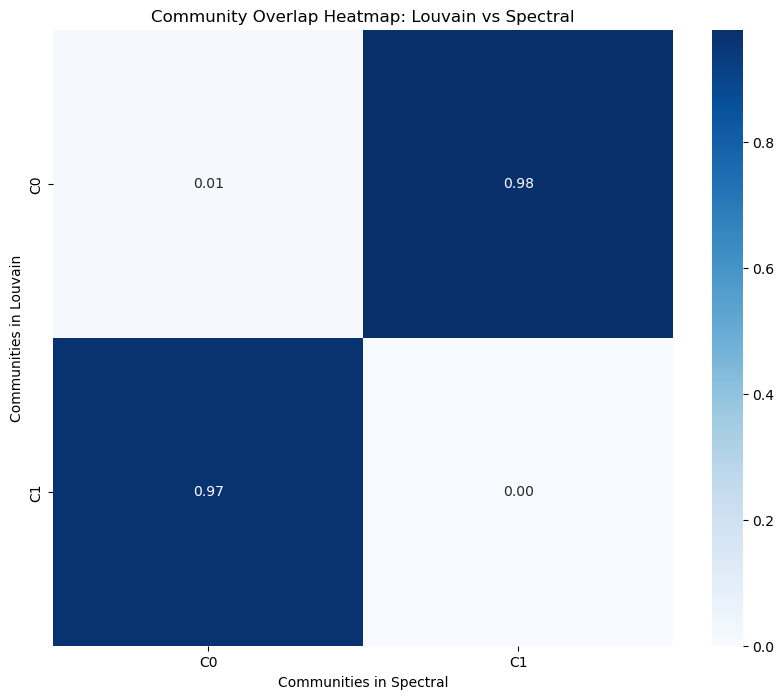

In [66]:
def plot_overlap_heatmap(method1_communities, method2_communities, overlap_scores, method1_label="Method 1", method2_label="Method 2"):
    """
    Plot a heatmap of community overlaps between two methods.
    Args:
        method1_communities (list): Communities detected by method 1.
        method2_communities (list): Communities detected by method 2.
        overlap_scores (list): Overlap scores for each pair of communities.
        method1_label (str): Label for method 1.
        method2_label (str): Label for method 2.
    """
    # Create an overlap matrix
    overlap_matrix = np.zeros((len(method1_communities), len(method2_communities)))
    for i, j, score in overlap_scores:
        overlap_matrix[i, j] = score
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(overlap_matrix, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=[f'C{j}' for j in range(len(method2_communities))],
                yticklabels=[f'C{i}' for i in range(len(method1_communities))])
    plt.xlabel(f"Communities in {method2_label}")
    plt.ylabel(f"Communities in {method1_label}")
    plt.title(f"Community Overlap Heatmap: {method1_label} vs {method2_label}")
    plt.show()

# Example usage:
selected_interval = '2008_2009'

communities_louvain = results_louvain[selected_interval]['communities']
communities_spectral = results_spectral[selected_interval]['communities']

# Calculate overlap scores
overlap_scores = calculate_community_overlap(communities_louvain, communities_spectral)

# Plot overlap heatmap
plot_overlap_heatmap(communities_louvain, communities_spectral, overlap_scores, 
                     method1_label="Louvain", method2_label="Spectral")

In [62]:
def compute_entropy(partition, total_elements):
    """
    Compute the entropy of a partition.
    Args:
        partition (list of lists): List of communities, each a list of elements.
        total_elements (int): Total number of elements in the dataset.
    Returns:
        float: Entropy of the partition.
    """
    # Filter out empty communities
    partition = [community for community in partition if community]

    # Calculate probabilities
    probabilities = [len(community) / total_elements for community in partition]

    # Add a small epsilon to avoid numerical instability
    epsilon = 1e-10
    return -sum(p * np.log(p + epsilon) for p in probabilities if p > 0)

def compute_mutual_information(partition1, partition2, total_elements):
    """
    Compute the mutual information between two partitions.
    Args:
        partition1 (list of lists): First partition.
        partition2 (list of lists): Second partition.
        total_elements (int): Total number of elements in the dataset.
    Returns:
        float: Mutual information between the partitions.
    """
    # Map elements to their community indices
    mapping1 = {element: idx for idx, community in enumerate(partition1) for element in community}
    mapping2 = {element: idx for idx, community in enumerate(partition2) for element in community}

    # Get the union of all unique elements
    unique_elements = set(mapping1.keys()).union(set(mapping2.keys()))

    # Compute joint probabilities
    joint_counts = Counter((mapping1.get(element, -1), mapping2.get(element, -1)) for element in unique_elements)
    mutual_info = 0
    epsilon = 1e-10  # Numerical stability

    for (c1, c2), count in joint_counts.items():
        p_c1_c2 = count / total_elements
        p_c1 = sum(1 for element in unique_elements if mapping1.get(element) == c1) / total_elements
        p_c2 = sum(1 for element in unique_elements if mapping2.get(element) == c2) / total_elements
        if p_c1_c2 > 0:
            mutual_info += p_c1_c2 * np.log(p_c1_c2 / (max(p_c1 * p_c2, epsilon)))

    return mutual_info

def compute_vi(partition1, partition2):
    """
    Compute the Variation of Information (VI) between two partitions.
    Args:
        partition1 (list of lists): First partition.
        partition2 (list of lists): Second partition.
    Returns:
        float: Variation of Information (VI) between the partitions.
    """
    # Check for empty partitions
    if not partition1 or not partition2:
        raise ValueError("Partitions must not be empty.")

    # Remove empty communities and duplicate elements
    partition1 = [list(set(community)) for community in partition1 if community]
    partition2 = [list(set(community)) for community in partition2 if community]

    # Calculate the total number of unique elements across both partitions
    unique_elements = set()
    for community in partition1:
        unique_elements.update(community)
    for community in partition2:
        unique_elements.update(community)
    total_elements = len(unique_elements)

    # Check for disjoint element sets
    if total_elements == 0:
        raise ValueError("Partitions have no overlapping elements or unique elements.")

    # Compute entropies for both partitions
    h1 = compute_entropy(partition1, total_elements)
    h2 = compute_entropy(partition2, total_elements)

    # Compute mutual information between the partitions
    mutual_info = compute_mutual_information(partition1, partition2, total_elements)

    # Log trivial partitions
    if len(partition1) == 1 or len(partition2) == 1:
        print("Warning: One of the partitions contains only a single community.")

    # Return the Variation of Information
    return h1 + h2 - 2 * mutual_info

def compute_normalized_vi(partition1, partition2):
    """
    Compute the Normalized Variation of Information (VI) between two partitions.
    Args:
        partition1 (list of lists): First partition.
        partition2 (list of lists): Second partition.
    Returns:
        float: Normalized VI between the partitions.
    """
    # Compute the unnormalized VI
    vi = compute_vi(partition1, partition2)

    # Calculate total entropy
    unique_elements = set()
    for community in partition1:
        unique_elements.update(community)
    for community in partition2:
        unique_elements.update(community)
    total_elements = len(unique_elements)

    h1 = compute_entropy(partition1, total_elements)
    h2 = compute_entropy(partition2, total_elements)

    total_entropy = h1 + h2

    # Normalize VI
    normalized_vi = vi / total_entropy if total_entropy > 0 else 0
    return normalized_vi

# Comparing communities across intervals
def compare_communities_across_intervals(results):
    """
    Compare community structures across intervals using VI.
    Args:
        results (dict): Results from analyze_intervals, containing communities for each interval.
    Returns:
        dict: Pairwise VI scores for all interval pairs.
    """
    intervals = list(results.keys())
    vi_scores = {}

    for i in range(len(intervals)):
        for j in range(i + 1, len(intervals)):
            interval1, interval2 = intervals[i], intervals[j]
            partition1 = results[interval1]['communities']
            partition2 = results[interval2]['communities']
            vi = compute_normalized_vi(partition1, partition2)
            vi_scores[(interval1, interval2)] = vi
            print(f"VI between {interval1} and {interval2}: {vi}")
    
    return vi_scores

if __name__ == '__main__':
    file_path = 'FTSE_100_standardized_returns.csv'
    interval = '2YE'

    # Generate results for Louvain and Spectral methods
    results_louvain = analyze_intervals(file_path, interval=interval, method="louvain")
    results_spectral = analyze_intervals(file_path, interval=interval, method="spectral")

    # Compute VI for all intervals
    vi_scores = {}

    for interval_key in results_louvain.keys():
        partition_louvain = results_louvain[interval_key]['communities']
        partition_spectral = results_spectral[interval_key]['communities']

        # Compute VI
        vi = compute_vi(partition_louvain, partition_spectral)
        vi_scores[interval_key] = vi
        print(f"Interval {interval_key}: VI between Louvain and Spectral = {vi}")


Detected 2 Initially
Final number of communities: 2
Interval 2001_2001: Found 2 communities.
Detected 3 Initially
Final number of communities: 3
Interval 2002_2003: Found 3 communities.
Detected 4 Initially
Final number of communities: 4
Interval 2004_2005: Found 4 communities.
Detected 3 Initially
Final number of communities: 3
Interval 2006_2007: Found 3 communities.
Detected 4 Initially
Final number of communities: 2
Interval 2008_2009: Found 2 communities.
Detected 2 Initially
Final number of communities: 2
Interval 2010_2011: Found 2 communities.
Interval 2001_2001: Found 2 communities.
Interval 2002_2003: Found 3 communities.
Interval 2004_2005: Found 4 communities.
Interval 2006_2007: Found 3 communities.
Interval 2008_2009: Found 2 communities.
Interval 2010_2011: Found 2 communities.
Interval 2001_2001: VI between Louvain and Spectral = -3.999998110515435e-10
Interval 2002_2003: VI between Louvain and Spectral = 0.09554807900959017
Interval 2004_2005: VI between Louvain and Sp

In [68]:
def print_communities_for_period(results_louvain, results_spectral, interval_key):
    """
    Print the communities detected by Louvain and Spectral methods for a specific interval.
    Args:
        results_louvain (dict): Communities detected by Louvain for all intervals.
        results_spectral (dict): Communities detected by Spectral for all intervals.
        interval_key (str): The specific time period to analyze (e.g., "2002_2003").
    """
    # Extract communities for the interval
    louvain_communities = results_louvain.get(interval_key, {}).get('communities', [])
    spectral_communities = results_spectral.get(interval_key, {}).get('communities', [])
    
    # Print Louvain communities
    print(f"Communities detected by Louvain for interval {interval_key}:")
    for i, community in enumerate(louvain_communities, 1):
        print(f"  Community {i}: {community}")
    
    # Print Spectral communities
    print(f"\nCommunities detected by Spectral for interval {interval_key}:")
    for i, community in enumerate(spectral_communities, 1):
        print(f"  Community {i}: {community}")

interval_key = '2008_2009' 
print_communities_for_period(results_louvain, results_spectral, interval_key)


Communities detected by Louvain for interval 2008_2009:
  Community 1: ['LLOY.L', 'SDR.L', 'LGEN.L', 'NWG.L', 'LSEG.L', 'LAND.L', 'PRU.L', 'UTG.L', 'HSBA.L', 'III.L', 'DPLM.L', 'AV.L', 'SGRO.L', 'DCC.L', 'BLND.L', 'STAN.L', 'BARC.L', 'PSN.L', 'BKG.L', 'HSX.L', 'NXT.L', 'SPX.L', 'VTY.L', 'EZJ.L', 'JD.L', 'BDEV.L', 'KGF.L', 'AHT.L', 'RTO.L', 'MKS.L', 'HWDN.L', 'SMDS.L', 'IMI.L', 'TW.L', 'WTB.L', 'AAL.L', 'SMT.L', 'RIO.L', 'CRDA.L', 'HLMA.L', 'RR.L', 'WPP.L', 'WEIR.L', 'ANTO.L', 'INF.L']
  Community 2: ['NG.L', 'DGE.L', 'SN.L', 'TSCO.L', 'GSK.L', 'BA.L', 'ABF.L', 'SHEL.L', 'ULVR.L', 'CPG.L', 'IMB.L', 'AZN.L', 'SGE.L', 'UU.L', 'BNZL.L', 'REL.L', 'BP.L', 'BATS.L', 'PSON.L', 'SVT.L', 'CNA.L', 'RKT.L', 'SBRY.L', 'VOD.L', 'SSE.L', 'SMIN.L', 'FCIT.L', 'BT-A.L']

Communities detected by Spectral for interval 2008_2009:
  Community 1: ['ABF.L', 'AZN.L', 'BA.L', 'BP.L', 'BATS.L', 'BT-A.L', 'BNZL.L', 'CNA.L', 'CPG.L', 'DGE.L', 'FCIT.L', 'GSK.L', 'IMB.L', 'NG.L', 'PSON.L', 'RKT.L', 'REL.L', 'RR.L', 